In [65]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load data 


In [34]:
FundAUM=1e9

In [35]:
mkts=get_market_list()
curr_px=get_most_liquid_price(mkts)
df=pd.DataFrame()
for m in mkts:
    df[m]=get_timeseries(m)
df=df.fillna(0)

# Portfolio with two different look backs with standard breakout models

* Models with 10 days and 80 days have the most diversification thus the most reduced drawdown

In [36]:
pos=tsmom_daily(df[mkts],10)
pnl_short=calc_pnl_wc(pos,df[mkts])
pos=tsmom_daily(df[mkts],80)
pnl_long=calc_pnl_wc(pos,df[mkts])
combined_pnl=(pnl_short*.5+pnl_long*.5)
scaling_factor=calc_scaling_factor(combined_pnl)
s_short=tsmom_daily_signal(df,10)
s_long=tsmom_daily_signal(df,80)
s_combined = (s_short*.5+s_long*.5)
lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)

In [37]:
mul=get_contract_multipliers()[df.columns]
cost=cost_model_position(lots,curr_px,mul,fee=0.0003)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


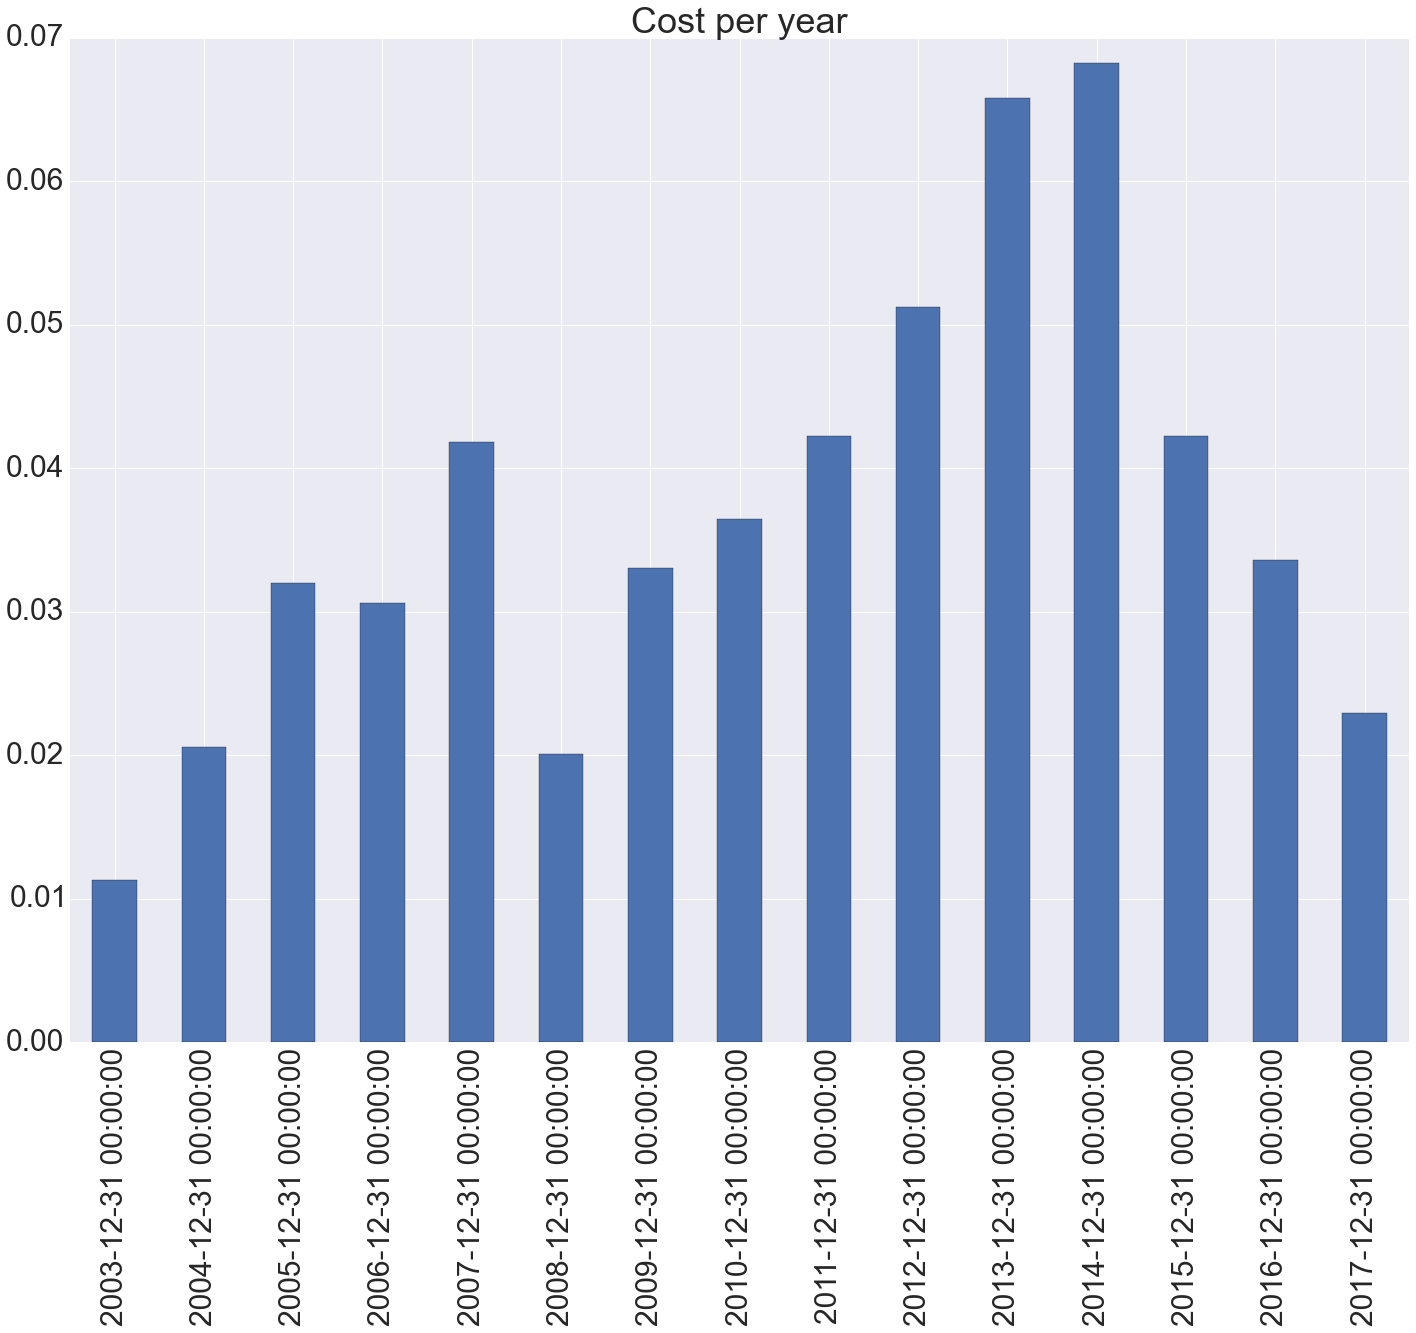

In [38]:
(cost.sum(axis=1).resample(rule='a',how='sum')/FundAUM).plot(kind='bar',title='Cost per year')

In [39]:
PNL = calc_pnl_position_wc(lots,df,curr_px,0.0003)/FundAUM

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


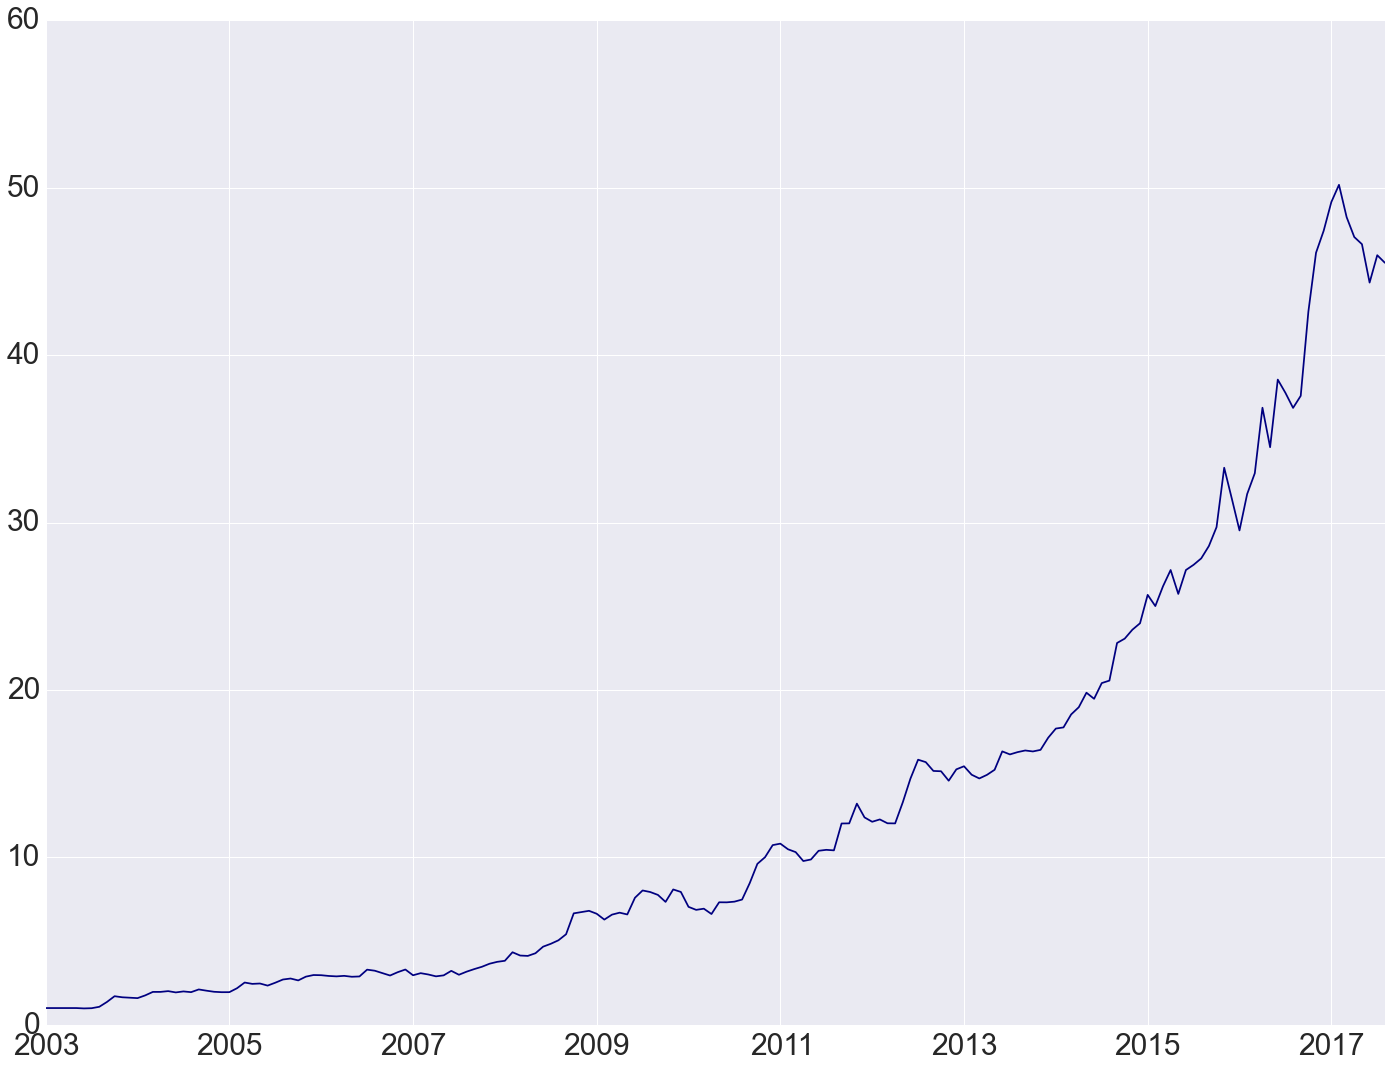

In [40]:
(PNL.sum(axis=1).resample(rule='m',how='sum')+1).cumprod().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


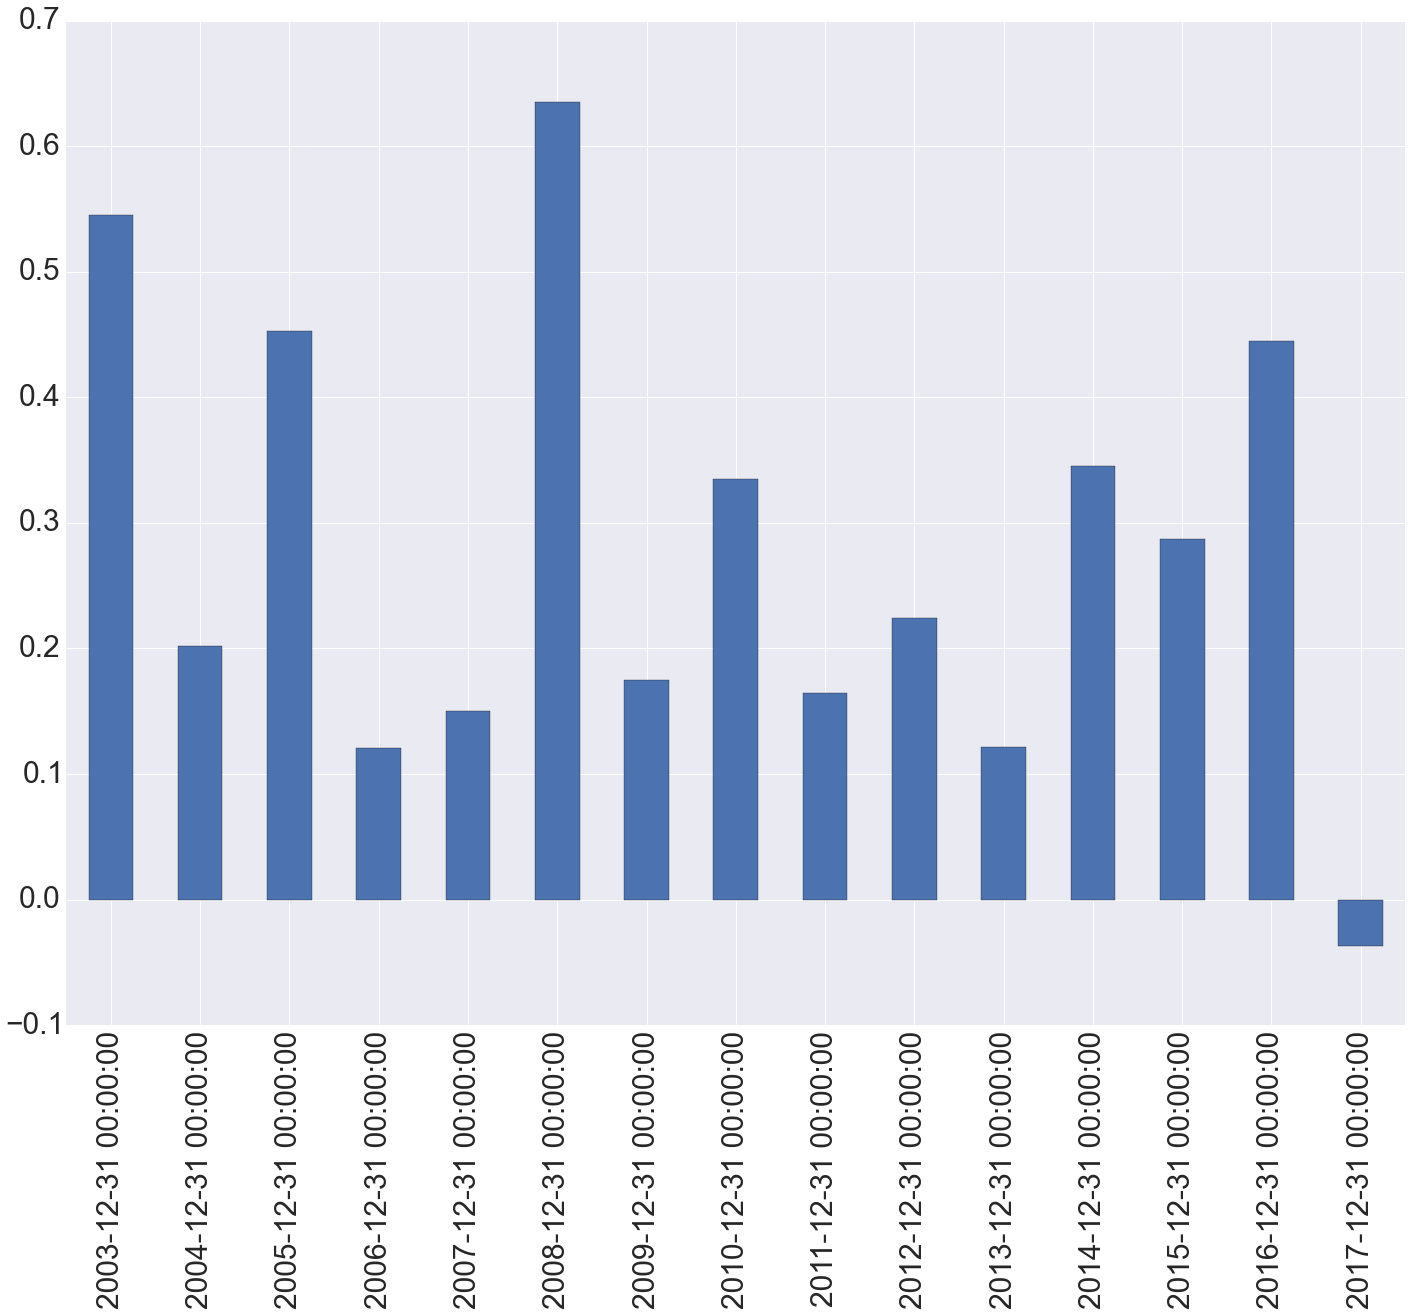

In [41]:
PNL.sum(axis=1).resample(rule='m',how='sum').resample(rule='a',how='sum').plot(kind='bar')

# Calculating fees

In [42]:
management_fee = 0.01
performance_fee = 0.2

In [43]:
gross_pnl=PNL.dropna(how='all').sum(axis=1).resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


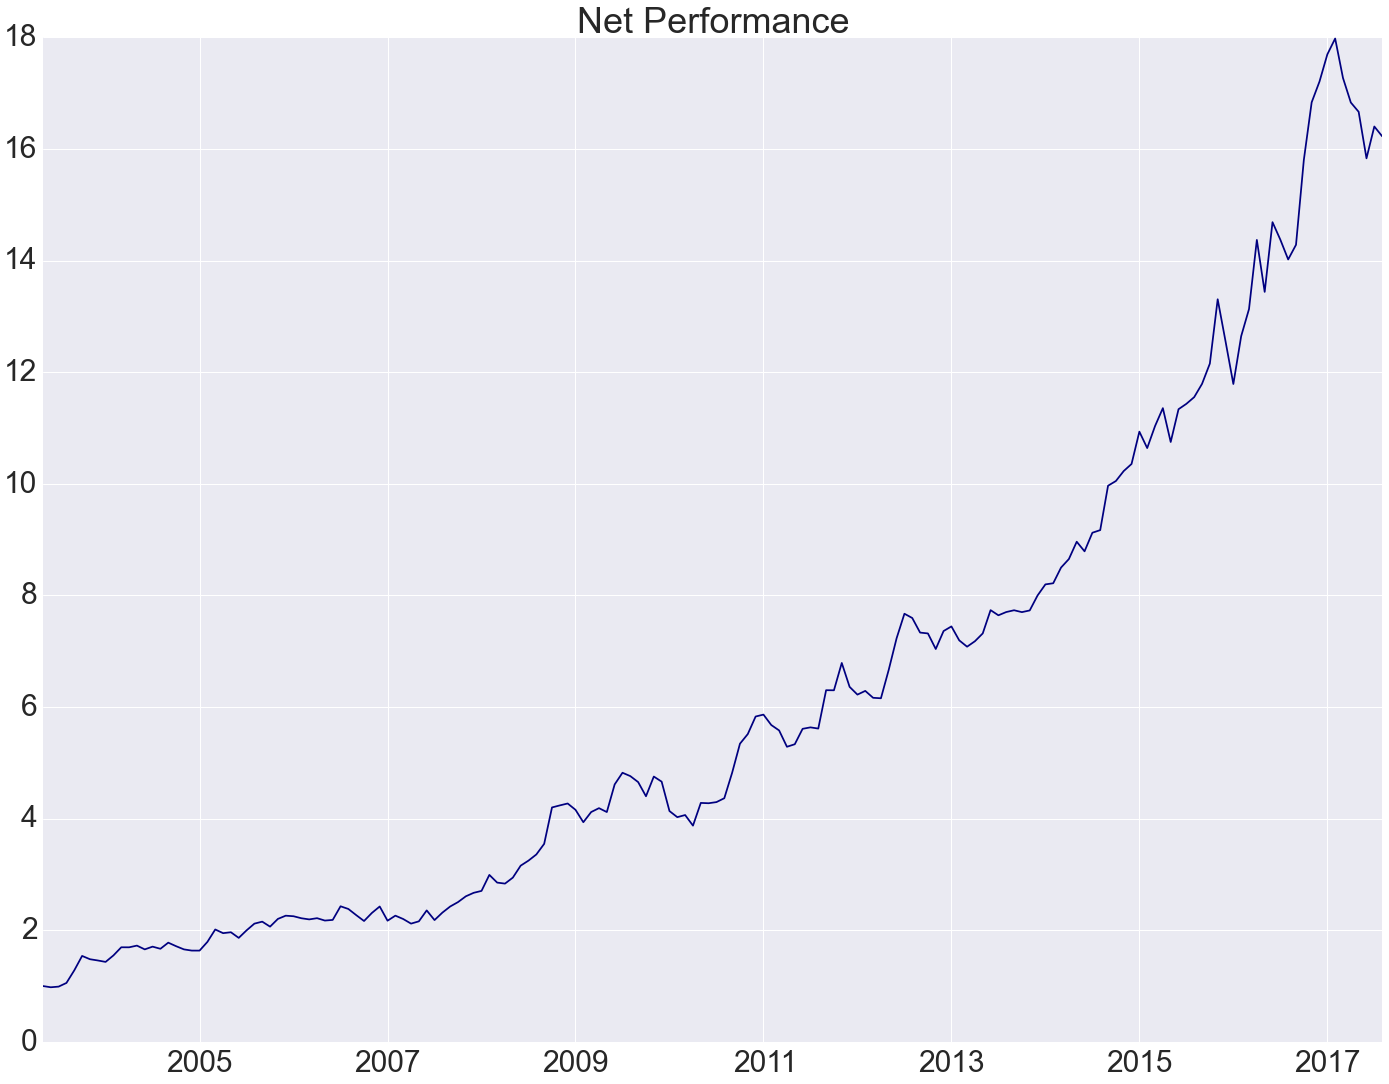

In [44]:
calc_net_performance(gross_pnl,management_fee,performance_fee).plot(colormap='jet',title='Net Performance')

In [45]:
indices=pd.DataFrame()
indices['Portfolio']=calc_net_performance(gross_pnl,management_fee,performance_fee)
indices['SSE Composite Index']=quandl.get('WFE/INDEXES_SHANGHAISESSECOMPOSITEINDEX',authtoken=token)

In [46]:
indices.pct_change().corr().round(3)

,Portfolio,SSE Composite Index
Portfolio,1.000,-0.043
SSE Composite Index,-0.043,1.000


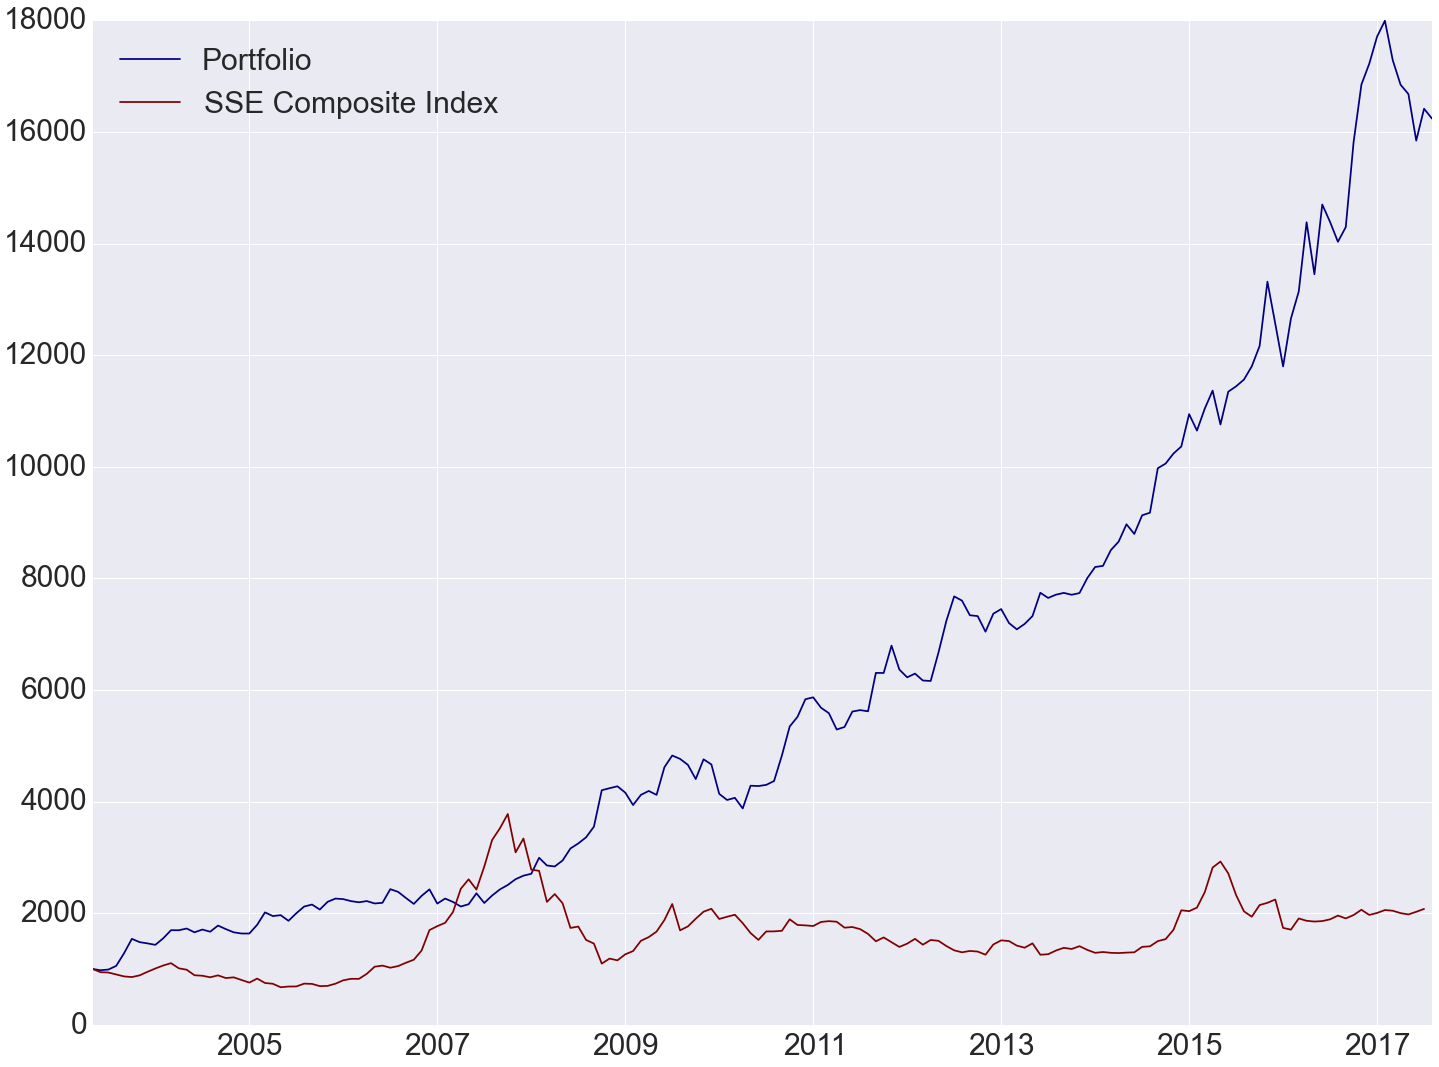

In [47]:
(1000*indices/indices.ix[0]).plot(colormap='jet')

In [48]:
(1000*indices/indices.ix[0]).to_csv('track.csv')
x=(1000*indices/indices.ix[0]).pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=12,adjust=True,com=24).corr(other=<Series>)
  if __name__ == '__main__':


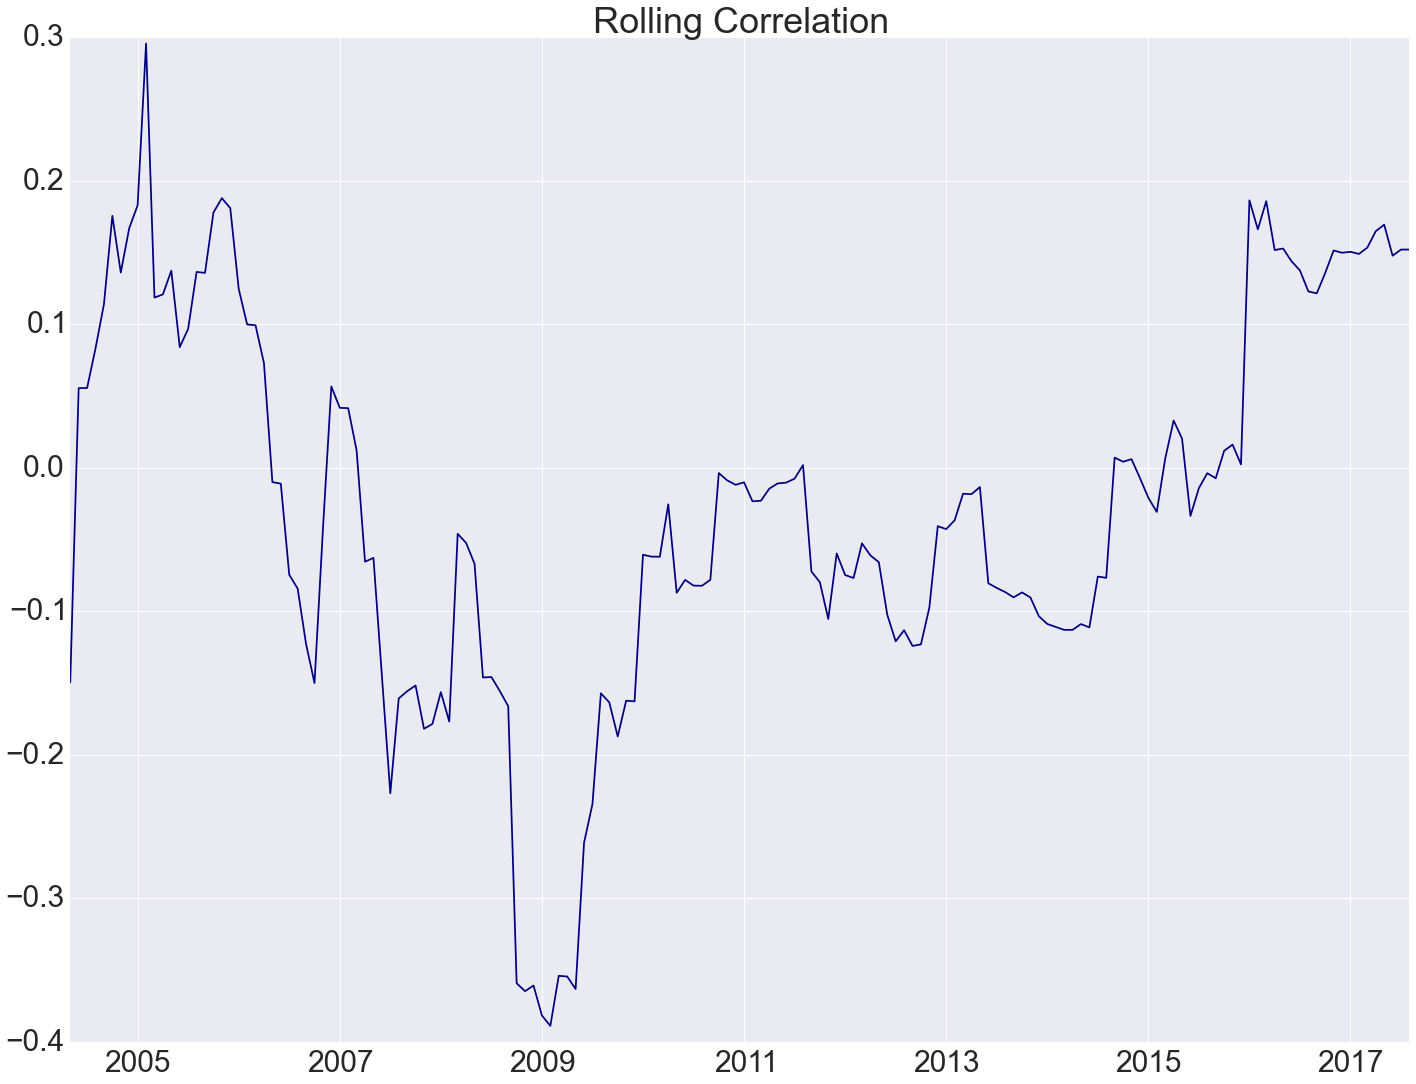

In [49]:
pd.ewmcorr(x.Portfolio,x['SSE Composite Index'],24,min_periods=12).dropna().plot(colormap='jet',title='Rolling Correlation')

In [50]:
HL=pd.read_csv('HL.csv',parse_dates=['Date']).set_index('Date').resample(rule='m',how='last')['2014-2':]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [51]:
compare=pd.DataFrame()
compare['Portfolio']=calc_net_performance(gross_pnl,management_fee,performance_fee)
compare['HL']=HL.SP

In [52]:
compare.pct_change().corr()

,Portfolio,HL
Portfolio,1.00000,0.75472
HL,0.75472,1.00000


In [53]:
volatility(indices)

Portfolio              18.37
SSE Composite Index    28.61
dtype: float64

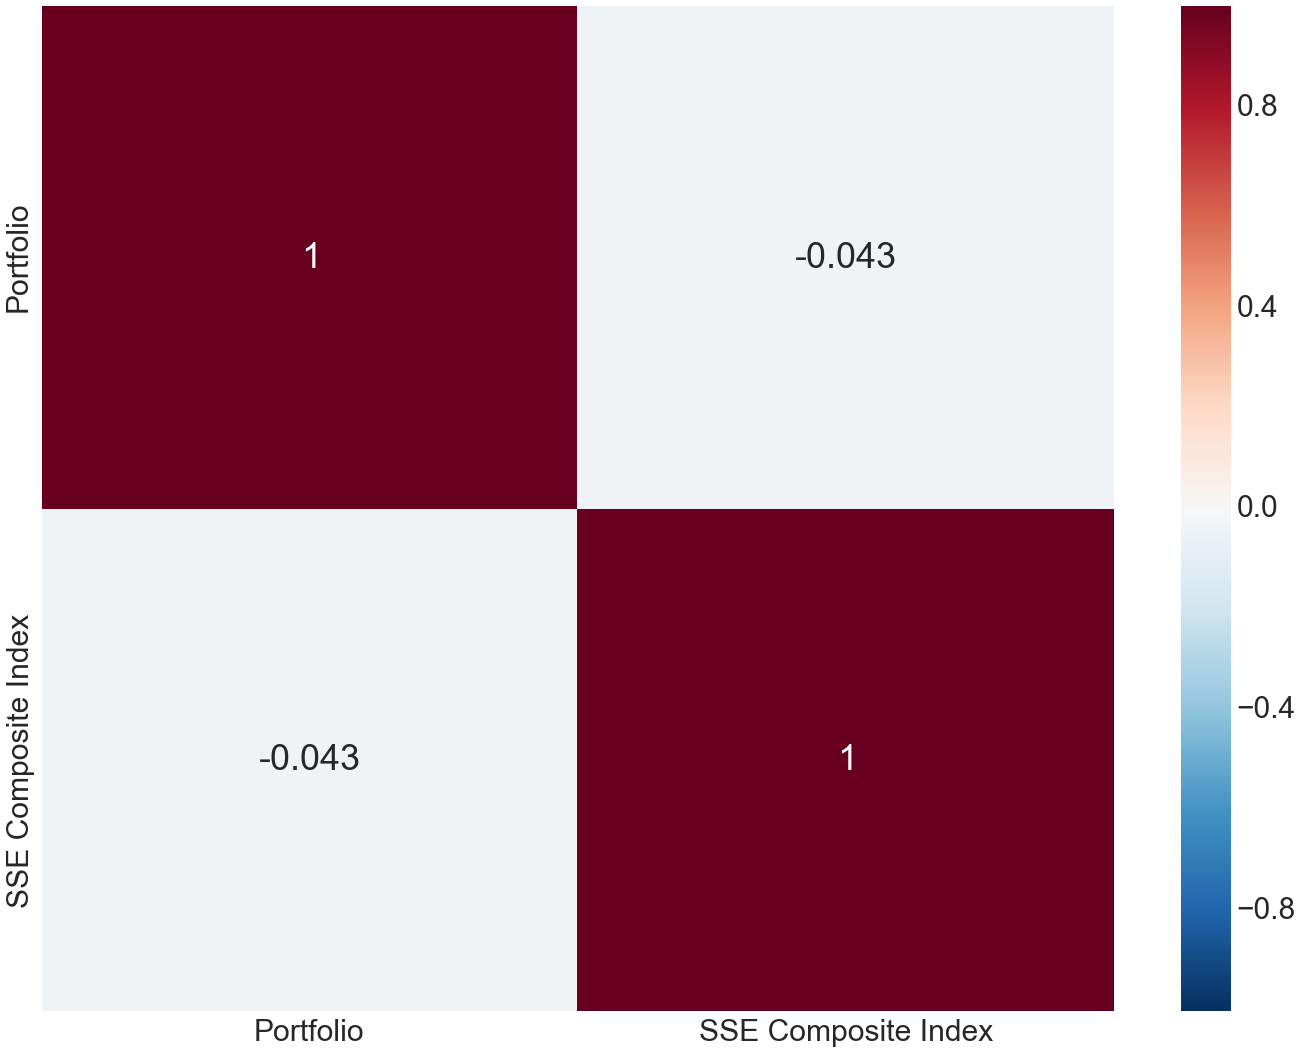

In [54]:
sns.heatmap(indices.pct_change().corr(),annot=True)

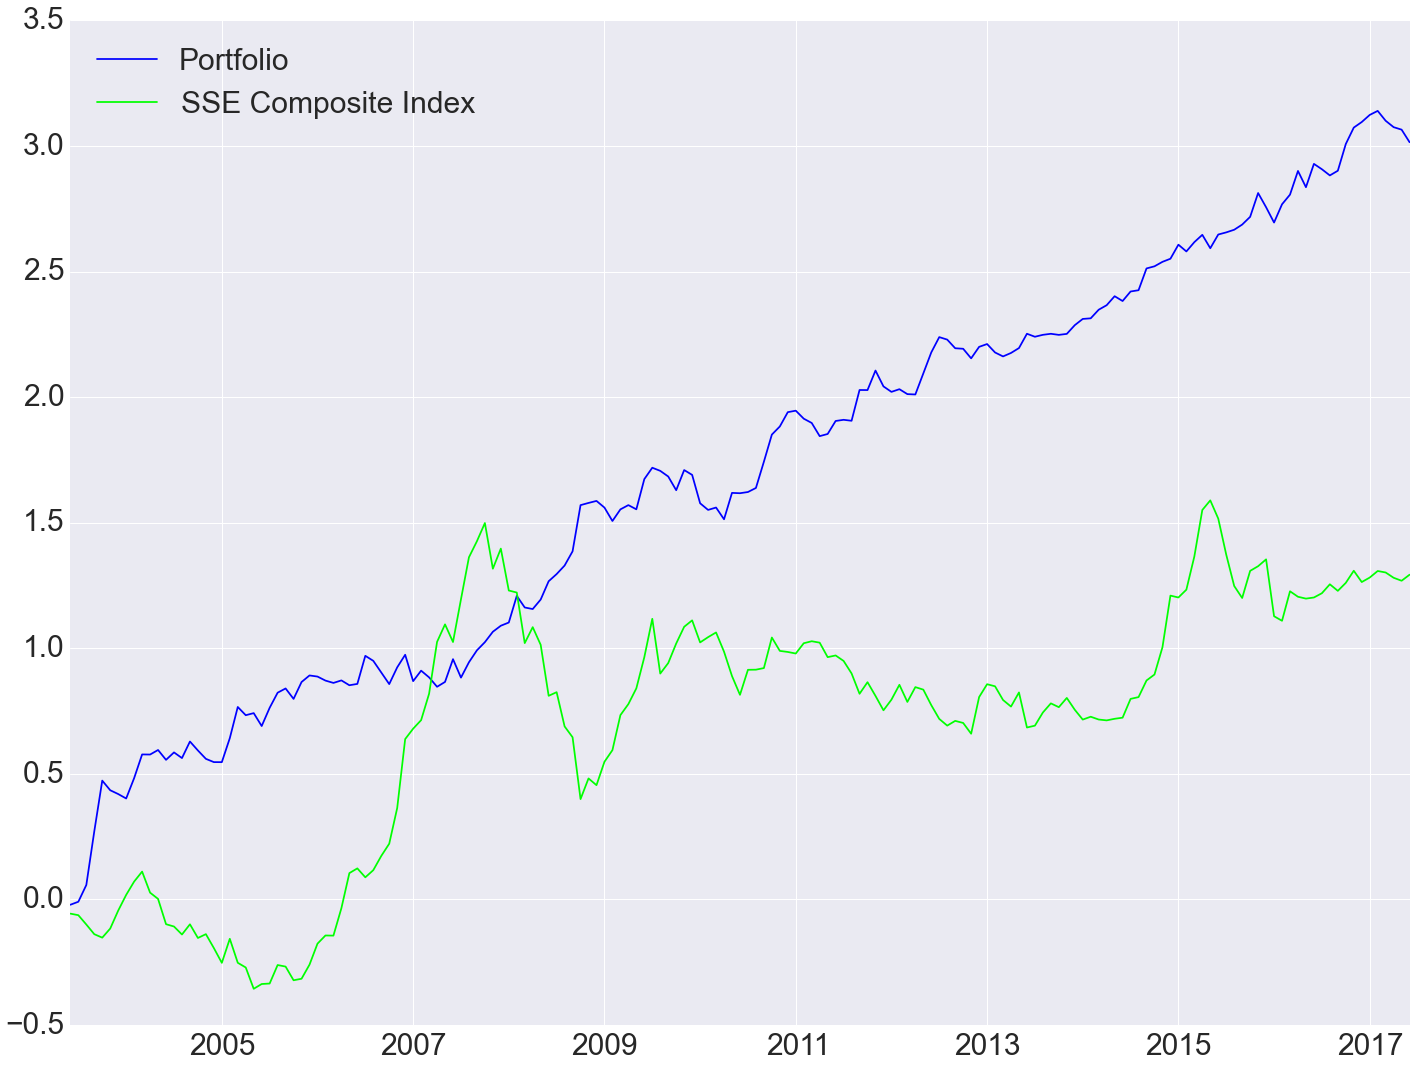

In [55]:
indices.pct_change().dropna().cumsum()[:-1].plot(colormap='brg')

# Total fee calculation

In [56]:
df=pd.DataFrame()
df['Net']=calc_net_performance(gross_pnl,management_fee,performance_fee)
df['Gross']=(gross_pnl+1).cumprod()
manager_pnl=(df.pct_change().Gross-df.pct_change().Net)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


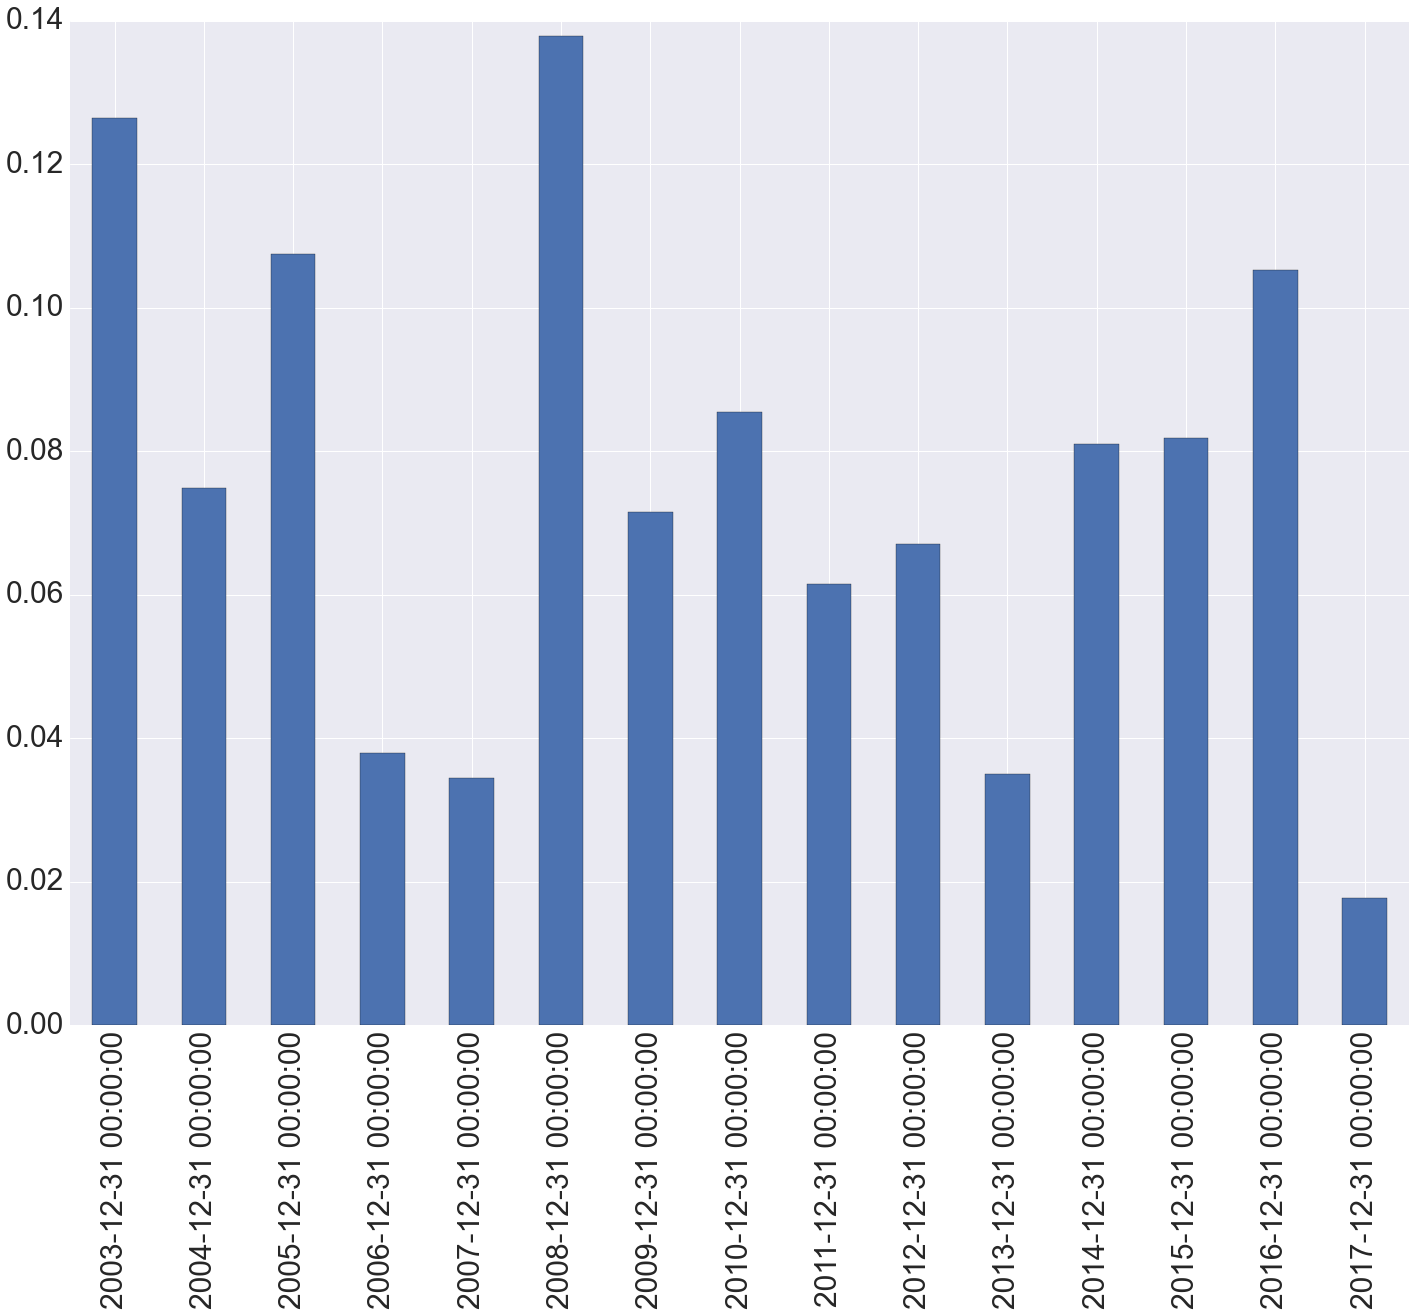

In [57]:
(manager_pnl).resample(rule='a',how='sum').plot(kind='bar')

In [58]:
DF=pd.DataFrame()
DF['Net Performance']=df.Net.resample(rule='a',how='last').pct_change()
DF['Manager Fees']=(manager_pnl).resample(rule='a',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


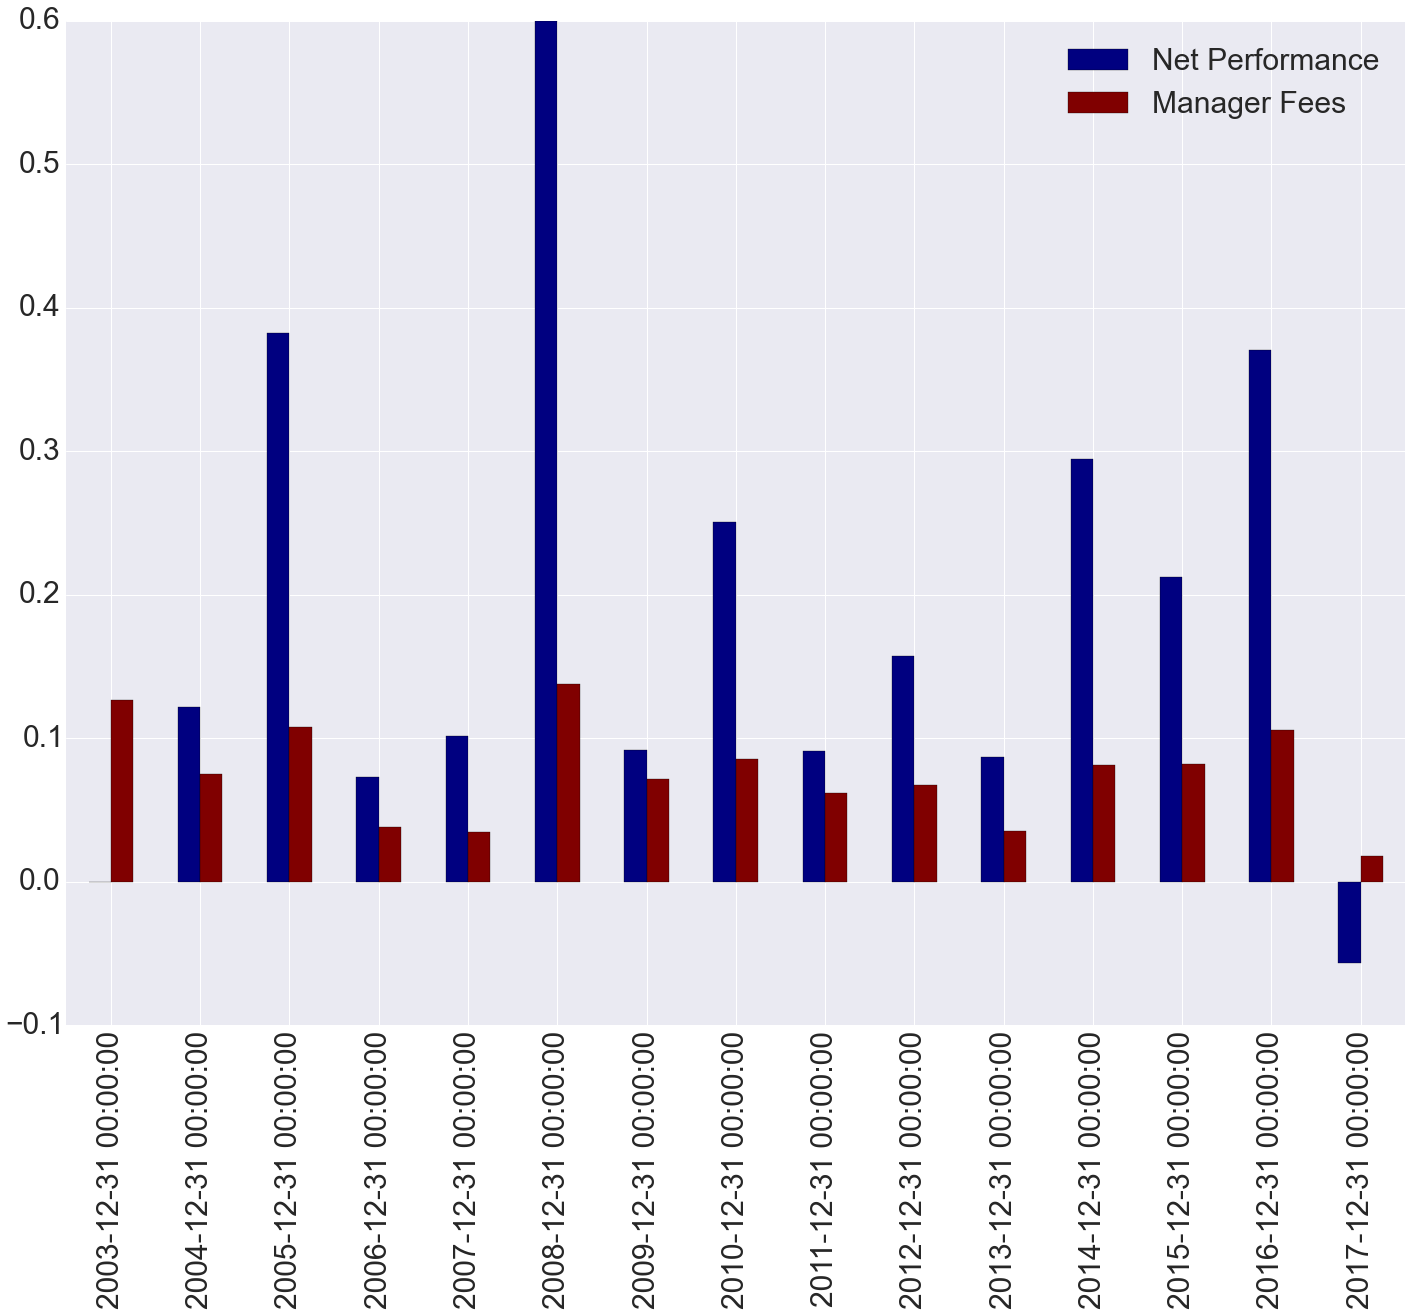

In [59]:
DF.plot(kind='bar',colormap='jet')

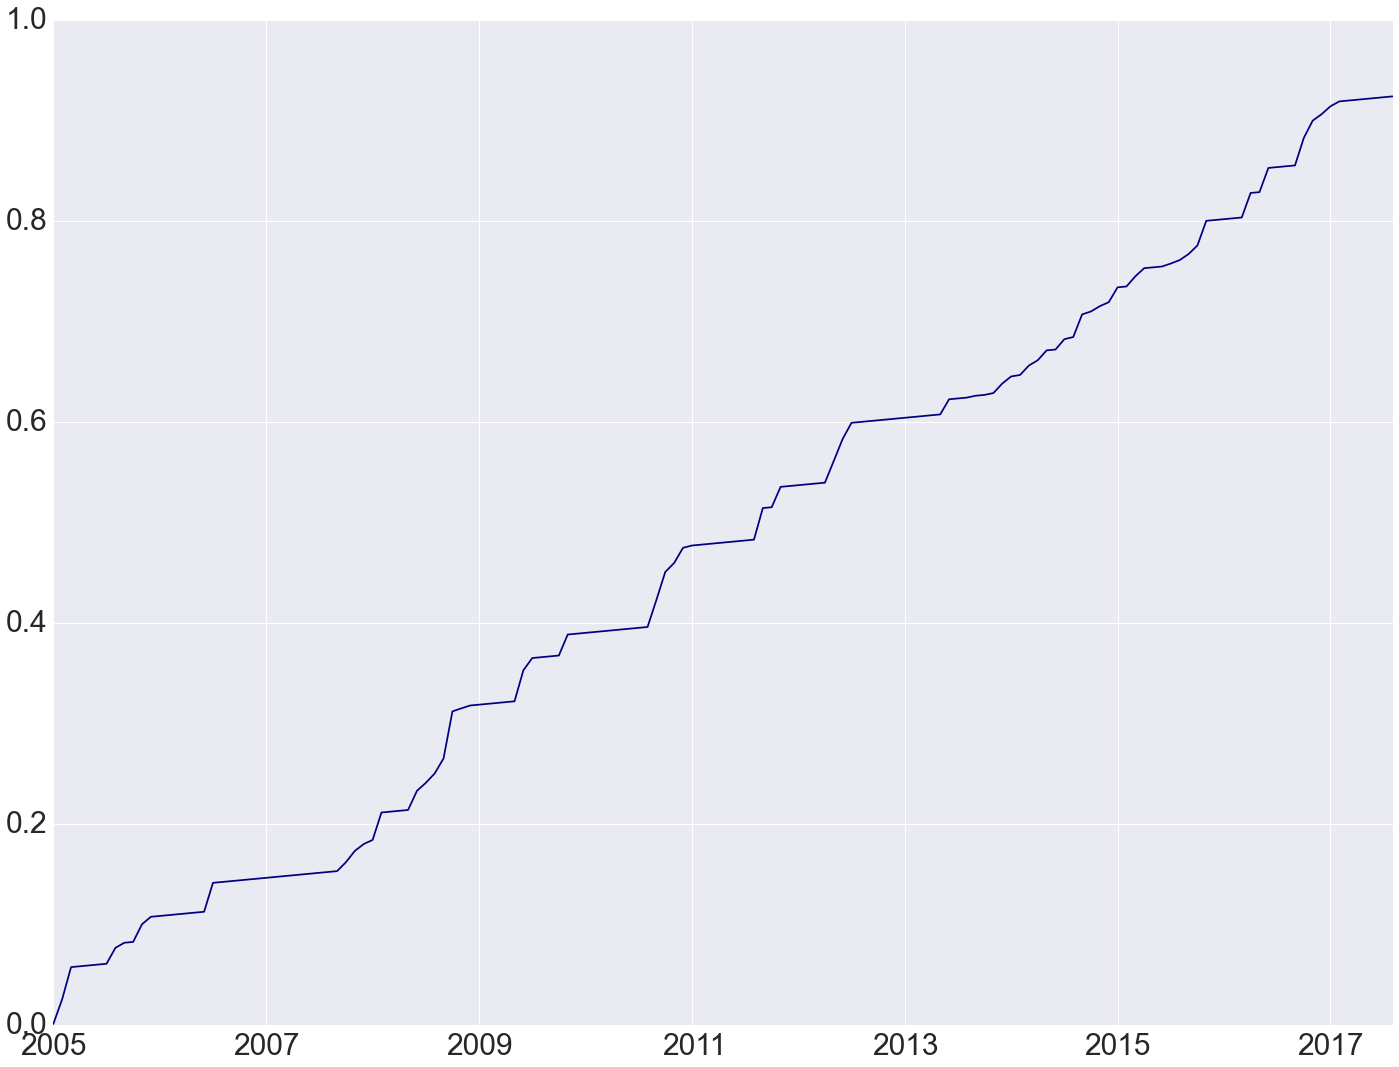

In [60]:
manager_pnl['2005':].cumsum().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


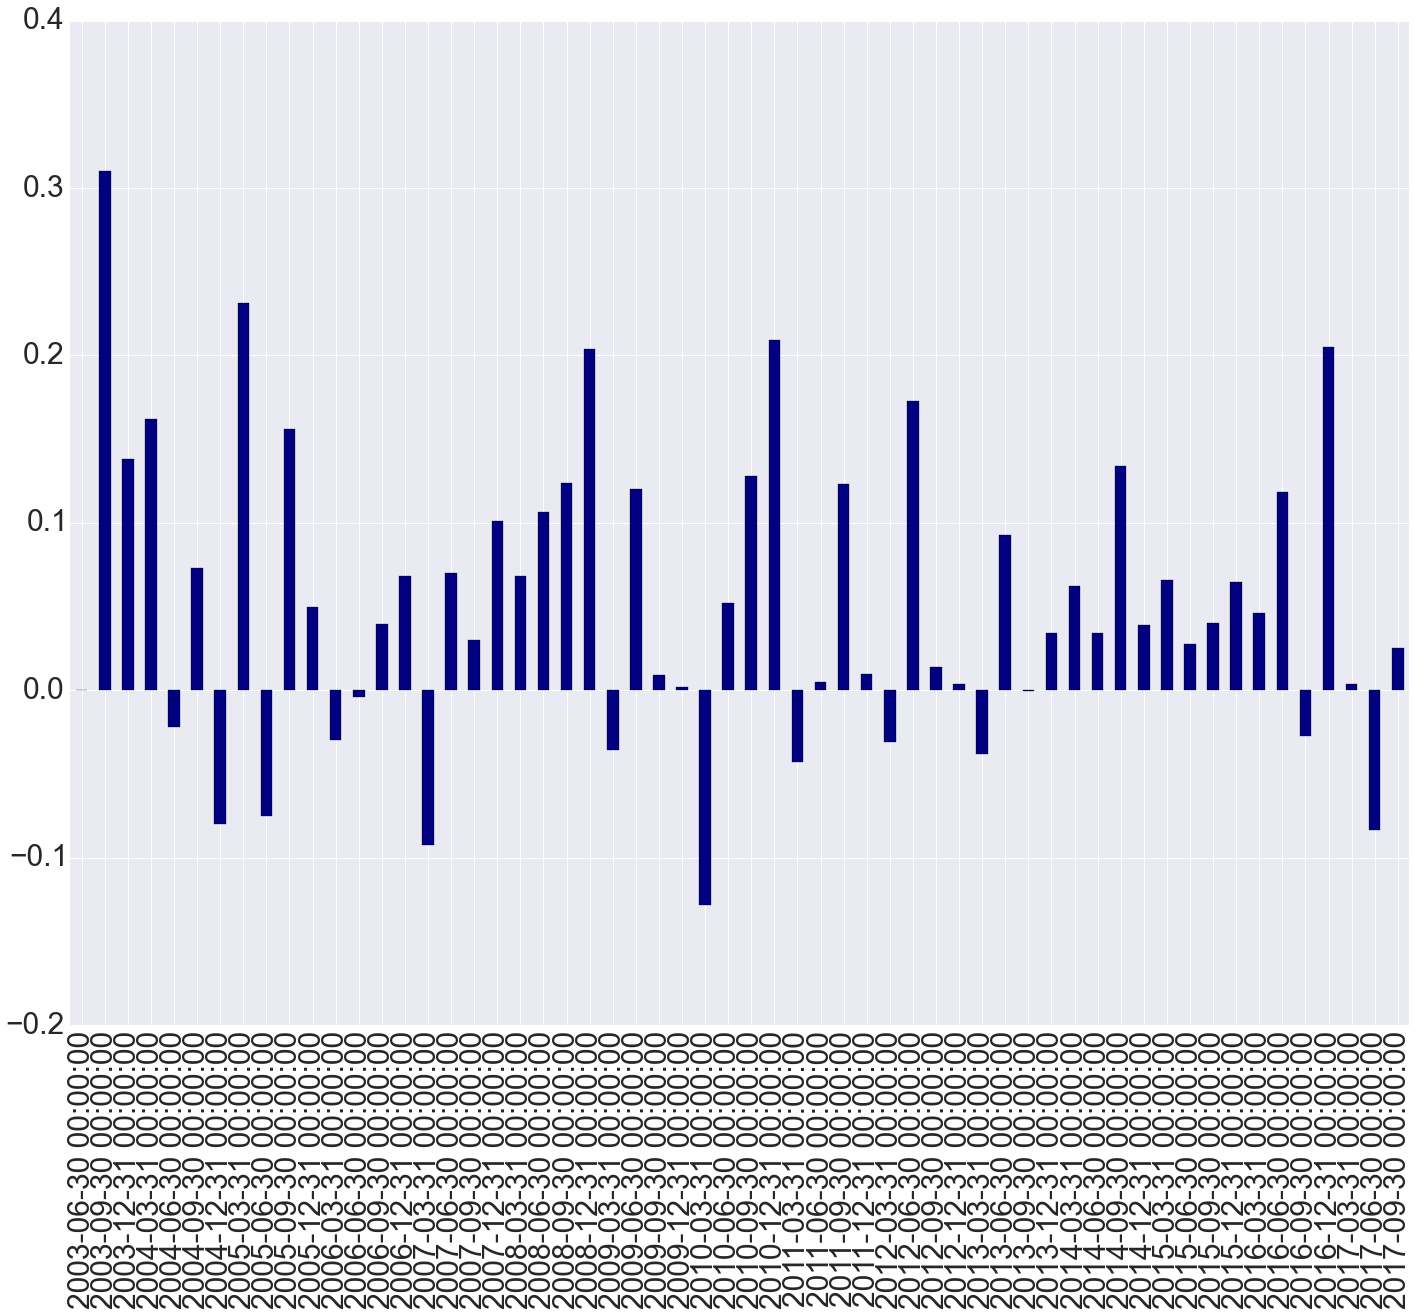

In [61]:
df.Net.resample(rule='q',how='last').pct_change().plot(kind='bar',colormap='jet')

In [62]:
manager_pnl.to_csv('manager_fees.csv')

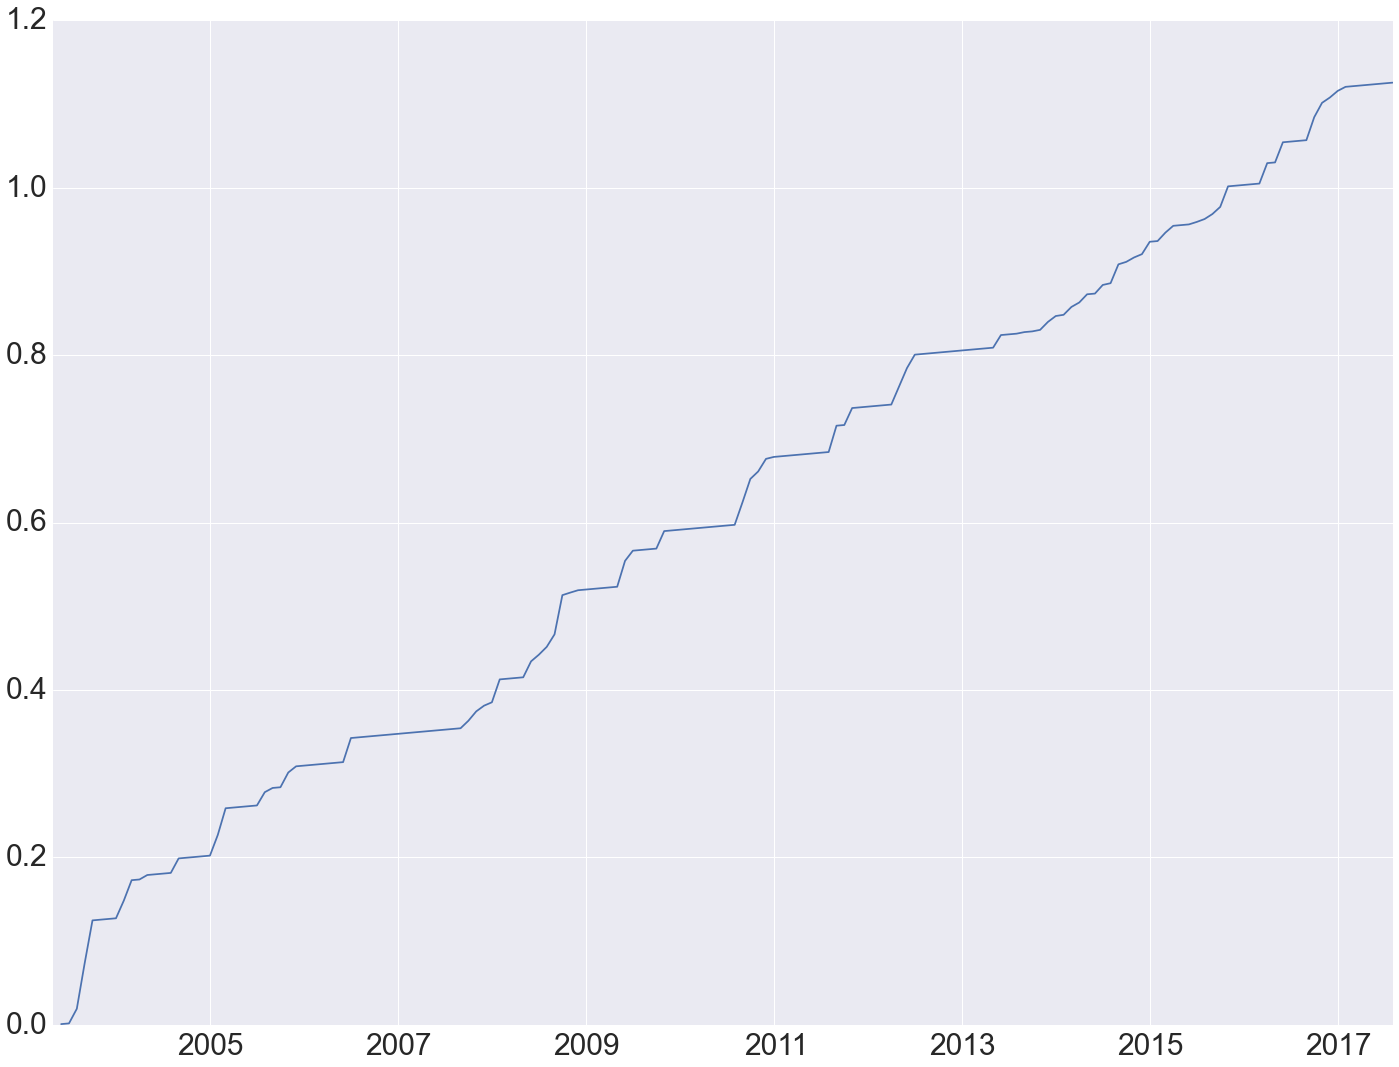

In [63]:
manager_pnl.cumsum().plot()

In [64]:
x['2017'].sum()

Portfolio             -0.054995
SSE Composite Index    0.054548
dtype: float64